# UMA Raw data EDA

## Import Libraries

In [2]:
# analysis
import numpy as np
import pandas as pd
import requests

# other
import warnings
import os

# visualisation libraries
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns

# Notebook styling
%matplotlib inline
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})
warnings.filterwarnings("ignore")


## Define Helper Functions

In [3]:
def get_api_token():
    """
    This function makes a POST request to Gometro's UMA REST API and returns a valid api token
    
    ------------------------------------
    Parameters:
        participant_id (str): column name of field containing the payload of the data
        date (str): column name of field containing the payload of the data
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    
    """
    
    # get dictionary of authorisation credentials
    task = {"username": "gometro-system-admin",
            "password": "3P6VP3ekMlPdi0IGM8VjJ6lEdZTNIuvR",
            "client_id": "gometro-uma-service",
            "grant_type": "password",
           }
    
    # make api request
    endpoint = 'https://identity.gometroapp.com/auth/realms/platform/protocol/openid-connect/token'
    response = requests.post(endpoint, data=task)
    
    # catch error
    if (response.status_code < 200) and (response.status_code >= 300):
        raise ValueError('POST /tasks/ {}'.format(response.status_code))
    
    return response.json()["access_token"]
    
    

In [4]:
def get_raw_user_data(pid, date, token):
    
    """
    This function makes a GET request to Gometro's UMA REST API and returns data from
    the API.
    
    ------------------------------------
    Parameters:
        participant_id (str): column name of field containing the payload of the data
        date (str): column name of field containing the payload of the data
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    
    """
    
    # define API headers
    headers = {'Authorization': f'Bearer {token}'}
    
    # make api request    
    endpoint = f'https://api.gometroapp.com/uma/v1/participants/{pid}/events/{date}'
    response = requests.get(endpoint, headers=headers)
    
    # catch error
    if (response.status_code < 200) and (response.status_code >= 300):
        raise ValueError('GET /tasks/ {}'.format(response.status_code))
    
    # import data
    df = pd.DataFrame(response.json())
    
    # select location data
    return df[df['type'] == 'LocationChanged']
    

In [12]:
def unpack_payload(df, payload_col = 'payload'):
    
    """
    This function takes a dataframe where the payload is in one column
    and creates a new column for each element in the payload
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): DataFrame containing column with payload
        payload_col (str): column name of field containing the payload of the data
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    """
    
    # make copy of dataframe
    df = df.copy()
    
    # import literal_eval function
    from ast import literal_eval

    # make list of column headers from keys
    payload_cols = literal_eval(df['payload'].iloc[0]).keys()
    
    # add columns for each column header to dataframe
    for col in payload_cols:
        df[col] = df['payload'].apply(lambda x: literal_eval(x)[col])
        
    # remove type and payload column
    df.drop(['type', 'payload'], axis=1, inplace=True)
    
    return df



In [6]:
def prep_data_raw(df):
    
    """
    This function takes data unpacked from GoMetro's UMA REST API using the
    unpack_payload function and returns a dataframe with the following columns
    added to the data
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): DataFrame containing column with payload
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    """
    
    # make copy of dataframe
    df = df.copy()
    
    # convert timetamps to date time
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # add features
    df['time_change'] = df['timestamp'].diff().dt.seconds
    df['speed_change'] = df['speed'].diff()
    df['acceleration'] = df['speed_change']/df['time_change']
    df['cumm_acceleration'] = df['acceleration'].cumsum()
    
    # make timestamp index
    df = df.set_index('timestamp')
    
    return df

In [7]:
def add_label_units(label):
    """
    This function generates a label with units
    ------------------------------------
    Parameters:
        label (str): column name of field we want units for
    
    Returns:
        (str): column name of field with the units such that '<label> (<unit>)'
    ------------------------------------
    Example:
    
    """
    
    # define dictionary of units for known column names
    units_dict = {'speed': 'm/s',
                  'acceleration': 'm/$s^{2}$',
                  'cumm_acceleration': 'm/$s^{2}$',
                  'bearing': '$&deg;$',
                  'latitude': '$&deg;$',
                  'longitude': '$&deg;$',
                  'accuracy': 'm',
                  'distance': 'm'
                  }
    
    # return units for known column names
    if label in units_dict.keys():
        return f'{label} [{units_dict[label]}]'
    
    # return label for unknown colum names
    return label

In [16]:
def raw_trip_analysis_plot(df, col, participant_id, date,
                           figures_dir=os.path.join('..','..', 'resources', 'reports','figures','raw_data_viz')):
    
    # 1. set size of figure
    fig, ax = plt.subplots(figsize=(400,10))
    
    
    # 2. plot figure
    ax.plot(df.loc[date][col], linestyle='-', color='b')

                        
    # 3. format figure
    # 3.1 set title of figure
    ax.set_title(f"{col} profile over time on {date}")
    
    # 3.2 set y_label
    ax.set_ylabel(add_label_units(col))
    
    # 3.3 set x_label
    ax.set_xlabel('time [24hrs]')
    
    # 3.4 set x-axis ticks to 1 min intervals
    xlocator = mdates.MinuteLocator(interval = 1)
    ax.xaxis.set_major_locator(xlocator)
    
    ## Format xtick labels as HH:MM
    xformatter = mdates.DateFormatter('%H:%M')
    plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
    
    # plt.xticks(rotation=90)
    plt.setp(ax.get_xticklabels(), rotation=90, ha='right')
    
    # 4.a define path
    file_path = os.path.join(figures_dir, participant_id, f'{date}_{col}_vs_time')
    
    # 4.b ensure that path directory exists
    file_dir = os.path.join(figures_dir, participant_id)
    if not os.path.exists(file_dir):
        os.mkdir(file_dir)
    
    # 5 save figure
    plt.savefig(file_path)
    
    # 6 display figure
    plt.show()

# Define Users to Visualize

Users to test:
```python
user_trips = [
    [25, '0ab124d9-edd9-410e-ab72-9fb8ffc7cedd', '1/18/2021'],
    [12, '0563a400-c33a-477f-a656-2a3309d490cb', '1/14/2021'],
    [5, '9c3e37e8-5b51-463c-8688-4452e0c39dbf', '1/13/2021'],
    [24, '0ab124d9-edd9-410e-ab72-9fb8ffc7cedd', '1/18/2021'],
    [4, '9c3e37e8-5b51-463c-8688-4452e0c39dbf', '1/13/2021']
]
```

Trip varification - Unsuccessful trips - Test Cycle 2:
```python
user_trips = [
    [17, '2e7bd09e-b11b-474f-aa2c-451828c4dc21', '1/14/2021'],
    [27, 'e59042cb-80f1-472b-80b3-ab69441511ac', '1/18/2021'],
    [63, 'a1e660a5-4b0f-4e4d-a631-97ca8264dd5b', '1/22/2021']
]

```

In [53]:
user_trips = [
    [17, '2e7bd09e-b11b-474f-aa2c-451828c4dc21', '1/14/2021'],
    [27, 'e59042cb-80f1-472b-80b3-ab69441511ac', '1/18/2021'],
    [63, 'a1e660a5-4b0f-4e4d-a631-97ca8264dd5b', '1/22/2021']
]

# Execute Visualisation

trip 25
trip 0ab124d9-edd9-410e-ab72-9fb8ffc7cedd
trip 2021-01-18
trip eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJXOEJqLU9Yd2VUNm5jNGNmRmxTYkJKM0hCdTdESGlfeXo5WjdaZGc0c1g0In0.eyJleHAiOjE2MTI2MTc4NjIsImlhdCI6MTYxMjYxNzU2MiwianRpIjoiMjMwOGM3MDgtNjc3Mi00YzhkLWIxNDQtMmVhMjc3YjEyOTVlIiwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS5nb21ldHJvYXBwLmNvbS9hdXRoL3JlYWxtcy9wbGF0Zm9ybSIsImF1ZCI6ImFjY291bnQiLCJzdWIiOiJiNDc0MjE4ZS0zNTM1LTQ1MTQtYjBiNy02YTI3ODIzNmFjMjMiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJnb21ldHJvLXVtYS1zZXJ2aWNlIiwic2Vzc2lvbl9zdGF0ZSI6ImNkYzcwNzJjLTkyZjctNDFlNy05Mjg3LTI1ODBkMTcwOTJlZiIsImFjciI6IjEiLCJyZWFsbV9hY2Nlc3MiOnsicm9sZXMiOlsib2ZmbGluZV9hY2Nlc3MiLCJzeXN0ZW1fYWRtaW4iLCJ1bWFfYXV0aG9yaXphdGlvbiJdfSwicmVzb3VyY2VfYWNjZXNzIjp7ImFjY291bnQiOnsicm9sZXMiOlsibWFuYWdlLWFjY291bnQiLCJtYW5hZ2UtYWNjb3VudC1saW5rcyIsInZpZXctcHJvZmlsZSJdfX0sInNjb3BlIjoicHJvZmlsZSBlbWFpbCIsImVtYWlsX3ZlcmlmaWVkIjpmYWxzZSwicHJlZmVycmVkX3VzZXJuYW1lIjoiZ29tZXRyby1zeXN0ZW0tYWRtaW4ifQ.MWRQO_XS5e8iB8xSNYzjOJvGsWyBn-4pdwxt6X50I3ADW0

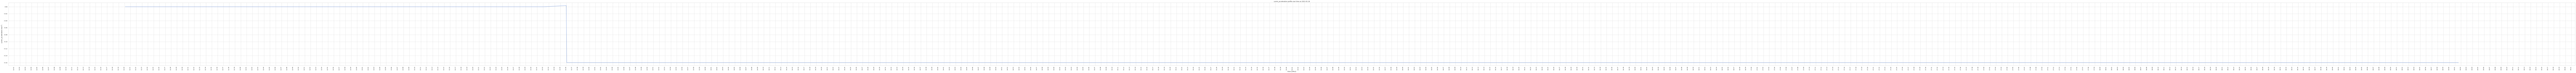

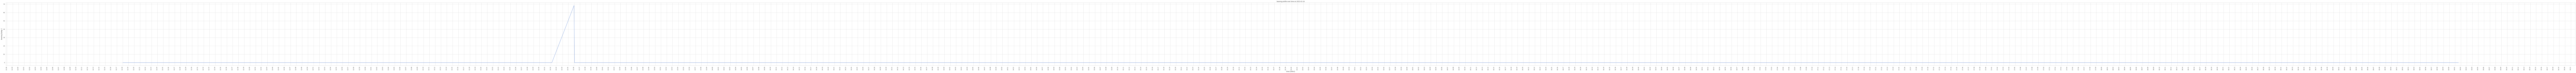

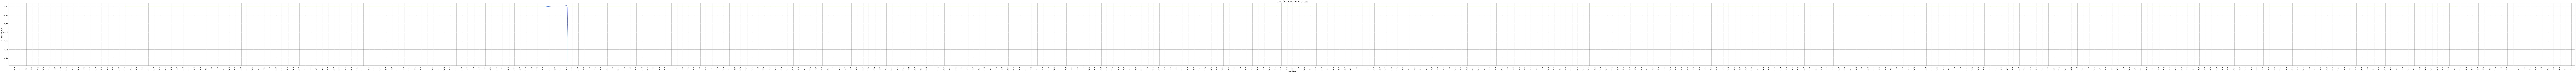

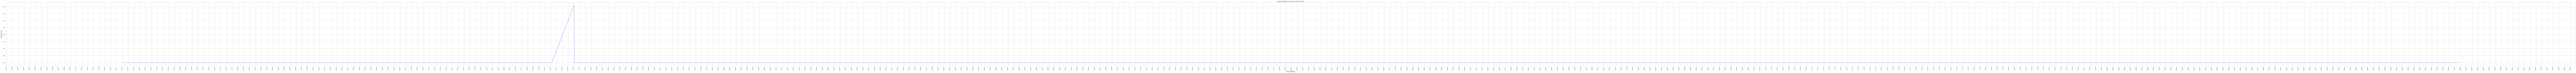

trip 12
trip 0563a400-c33a-477f-a656-2a3309d490cb
trip 2021-01-14
trip eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJXOEJqLU9Yd2VUNm5jNGNmRmxTYkJKM0hCdTdESGlfeXo5WjdaZGc0c1g0In0.eyJleHAiOjE2MTI2MTc4NjIsImlhdCI6MTYxMjYxNzU2MiwianRpIjoiMjMwOGM3MDgtNjc3Mi00YzhkLWIxNDQtMmVhMjc3YjEyOTVlIiwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS5nb21ldHJvYXBwLmNvbS9hdXRoL3JlYWxtcy9wbGF0Zm9ybSIsImF1ZCI6ImFjY291bnQiLCJzdWIiOiJiNDc0MjE4ZS0zNTM1LTQ1MTQtYjBiNy02YTI3ODIzNmFjMjMiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJnb21ldHJvLXVtYS1zZXJ2aWNlIiwic2Vzc2lvbl9zdGF0ZSI6ImNkYzcwNzJjLTkyZjctNDFlNy05Mjg3LTI1ODBkMTcwOTJlZiIsImFjciI6IjEiLCJyZWFsbV9hY2Nlc3MiOnsicm9sZXMiOlsib2ZmbGluZV9hY2Nlc3MiLCJzeXN0ZW1fYWRtaW4iLCJ1bWFfYXV0aG9yaXphdGlvbiJdfSwicmVzb3VyY2VfYWNjZXNzIjp7ImFjY291bnQiOnsicm9sZXMiOlsibWFuYWdlLWFjY291bnQiLCJtYW5hZ2UtYWNjb3VudC1saW5rcyIsInZpZXctcHJvZmlsZSJdfX0sInNjb3BlIjoicHJvZmlsZSBlbWFpbCIsImVtYWlsX3ZlcmlmaWVkIjpmYWxzZSwicHJlZmVycmVkX3VzZXJuYW1lIjoiZ29tZXRyby1zeXN0ZW0tYWRtaW4ifQ.MWRQO_XS5e8iB8xSNYzjOJvGsWyBn-4pdwxt6X50I3ADW0

KeyError: 'type'

In [54]:
# define base directory for all figures
work_dir = os.path.join('..','..', 'resources', 'reports','figures','raw_data_viz')

# define variables to visualise
viz_cols = ['cumm_acceleration', 'bearing', 'acceleration', 'speed']

# get token to access api
token = get_api_token()

# for each trip
for trip, participant, date in user_trips:
    
    print(f'trip {trip}')
    
    # convert date format
    old_date = date.split("/")
    new_date = old_date[2] + "-" + old_date[0].zfill(2) + "-"+ old_date[1]
    
    print(f'trip {participant}')
    print(f'trip {new_date}')
    print(f'trip {token}')
    
    # generate visuals from API data if token is valid
    try:
        df_api = get_raw_user_data(participant, new_date, token)
        df_raw = unpack_payload(df_api)
        df_raw_extra = prep_data_raw(df_raw)

        for col in viz_cols:
            raw_trip_analysis_plot(df_raw_extra, col, participant, new_date, work_dir)
            
        # if token not valid, get token then visualize
    except ValueError as token_error:
        print(token_error)
        print('refreshing authorisation...')
        token = get_api_token()
        print(f'trip {token}')
        dataset = get_raw_user_data(participant, new_date, token)
        df_raw = unpack_payload(df_api)
        df_raw_extra = prep_data_raw(df_raw)

        for col in viz_cols:
            raw_trip_analysis_plot(df_raw_extra, col, participant, new_date, work_dir)
            
    # if date selected is out of range
    except KeyError as date_error:
        print(date_error)
        
        df_api = get_raw_user_data(participant, new_date, token)
        df_raw = unpack_payload(df_api)
        df_raw_extra = prep_data_raw(df_raw)
        
        # indicate correct value for trip and continue
        min_date = str(df_raw_extra.index.min().date())
        max_date = str(df_raw_extra.index.max().date())
        
        print('date passed in: ' + new_date)
        print(f'data date range: {min_date} to {max_date}')
        print('continue to next trip...')
        continue



In [55]:
# define authorisation parameters
task = {"username": "gometro-system-admin",
        "password": "3P6VP3ekMlPdi0IGM8VjJ6lEdZTNIuvR",
        "client_id": "gometro-uma-service",
        "grant_type": "password",
       }

# get authorisation credentials
endpoint = 'https://identity.gometroapp.com/auth/realms/platform/protocol/openid-connect/token'
resp = requests.post(endpoint, data=task)

if (resp.status_code < 200) and (resp.status_code >= 300):
    raise ValueError('POST /tasks/ {}'.format(resp.status_code))

# get access token
token = resp.json()["access_token"]

# get headers
headers = {
    'Authorization': f'Bearer {token}',
}

pid = '0563a400-c33a-477f-a656-2a3309d490cb'
new_date = '2021-01-14'

# get data
endpoint = f'https://api.gometroapp.com/uma/v1/participants/{pid}/events/{new_date}'
response = requests.get(endpoint, headers=headers)
response.json()

[]

In [22]:
df_api = get_raw_user_data('0ab124d9-edd9-410e-ab72-9fb8ffc7cedd', '2021-01-18', token)
print(df_api.shape)
df_api.head()

(25, 3)


timestamp             type  \
2   2021-01-18T12:18:00.422Z  LocationChanged   
10  2021-01-18T12:20:05.272Z  LocationChanged   
25  2021-01-18T12:31:00.772Z  LocationChanged   
50  2021-01-18T12:51:13.992Z  LocationChanged   
88  2021-01-18T13:22:01.718Z  LocationChanged   

                                              payload  
2   {"provider":"network","latitude":52.418213,"lo...  
10  {"provider":"network","latitude":52.418303,"lo...  
25  {"provider":"network","latitude":52.4181942,"l...  
50  {"provider":"network","latitude":52.4182344,"l...  
88  {"provider":"network","latitude":52.4181806,"l...

In [25]:
df_raw = unpack_payload(df_api)
print(df_raw.shape)
df_raw.head()

(2749, 7)


timestamp provider   latitude  longitude  accuracy     bearing  \
12  2021-01-13T03:05:34Z      gps -33.868598  18.538878       2.8    1.400000   
13  2021-01-13T03:06:10Z      gps -33.868642  18.538938       2.4  105.760002   
15  2021-01-13T03:07:26Z      gps -33.868562  18.538917       2.9  102.550003   
20  2021-01-13T03:10:04Z      gps -33.868642  18.538920       2.9  335.829987   
34  2021-01-13T03:21:06Z      gps -33.868740  18.538948       1.2  188.720001   

       speed  
12  0.017501  
13  1.067019  
15  0.146181  
20  0.579577  
34  0.317584

In [26]:
df_raw_extra = prep_data_raw(df_raw)
print(df_raw_extra.shape)
df_raw_extra.head()

(2749, 10)


provider   latitude  longitude  accuracy  \
timestamp                                                            
2021-01-13 03:05:34+00:00      gps -33.868598  18.538878       2.8   
2021-01-13 03:06:10+00:00      gps -33.868642  18.538938       2.4   
2021-01-13 03:07:26+00:00      gps -33.868562  18.538917       2.9   
2021-01-13 03:10:04+00:00      gps -33.868642  18.538920       2.9   
2021-01-13 03:21:06+00:00      gps -33.868740  18.538948       1.2   

                              bearing     speed  time_change  speed_change  \
timestamp                                                                    
2021-01-13 03:05:34+00:00    1.400000  0.017501          NaN           NaN   
2021-01-13 03:06:10+00:00  105.760002  1.067019         36.0      1.049519   
2021-01-13 03:07:26+00:00  102.550003  0.146181         76.0     -0.920838   
2021-01-13 03:10:04+00:00  335.829987  0.579577        158.0      0.433396   
2021-01-13 03:21:06+00:00  188.720001  0.317584        662.0     -0.261994   

                           acceleration  cumm_acceleration  
timestamp                                                   
2021-01-13 03:05:34+00:00           NaN                NaN  
2021-01-13 03:06:10+00:00      0.029153           0.029153  
2021-01-13 03:07:26+00:00     -0.012116           0.017037  
2021-01-13 03:10:04+00:00      0.002743           0.019780  
2021-01-13 03:21:06+00:00     -0.000396           0.019384

In [28]:
# KeyError
# for col in viz_cols:
#     raw_trip_analysis_plot(df_raw_extra, col, participant, new_date, work_dir)

In [47]:
min_date = str(df_raw_extra.index.min().date())
print(min_date)
max_date = str(df_raw_extra.index.max().date())
print(max_date)

2021-01-13
2021-01-14


In [45]:
str(df_raw_extra.index.min().date())

'2021-01-13'

In [46]:
str(df_raw_extra.index.max().date())

'2021-01-14'

In [ ]:
df_raw_extra.index.min().date

In [ ]:
df_raw_extra.index.min().date

# Serialize API Authentication Data

In [1]:
data = {
    "username": "gometro-system-admin",
    "password": "3P6VP3ekMlPdi0IGM8VjJ6lEdZTNIuvR",
    "client_id": "gometro-uma-service",
    "grant_type": "password",
       }
data

{'username': 'gometro-system-admin',
 'password': '3P6VP3ekMlPdi0IGM8VjJ6lEdZTNIuvR',
 'client_id': 'gometro-uma-service',
 'grant_type': 'password'}

In [3]:
import json
with open("../../../../Admin/authentication_files/uma_api_cred_2021-01-21.json", "w") as write_file:
    json.dump(data, write_file)